In [1]:
import sims
import numpy as np
import msprime
import pandas as pd

import useful
import seaborn
import matplotlib
from matplotlib import pyplot as plt
from importlib import reload


In [2]:
# Generation time, mutation rate and recomination rate
RR = 1e-8
MU = 1.29e-8 
GEN_time = 29.0 

# Split Times
T_NEAND_migration = 55000 #time of Neanderthal migration into Out_of_africa population
T_NEAND_AMH = 550000 # split time between AMH and Neanderthal
T_OOF_AF = 65700 # Out_of_Africa migration time
T_NEAND_samples = 35000
T_SECOND_NEAND_MIGRATION = 30000

# Effective population size
N_ANC = 18500 # N_e of common  AMH and NEanderthal population 
N_ND = 3400 # N_e of Neanderthal
N_AMH = 23000 # N_e of AMH
N_OOF = 1861 # N_e of Out_of_Africa population
N_AF = 27600 # N_e of Africans
N_EU = 13377 #N_e of Europeans

N_EU_bottleneck = 1080
N_EU_growth = 1450
T_EU_growth = 31900
gr_rate = 0.00202
Portion_admix = 0.1
Portion_admix2 = 0.1

len_sequence = 2e7 # DNA sequence length

n = 50 # number of generated   AF samples
n_neand = 6 #number of generated Neanderthals

rand_sd =1234 #random seed

T = np.array([T_NEAND_migration, T_NEAND_AMH, T_OOF_AF, T_SECOND_NEAND_MIGRATION])/GEN_time
print(T)


[ 1896.55172414 18965.51724138  2265.51724138  1034.48275862]


In [3]:
N_ND = 3400 # N_e of Neanderthal
N_e = np.array([N_ANC, N_ND, N_AMH, N_OOF, N_AF, N_EU])

n_eu=100
ts3400 =sims.history_archaic(GEN_time, len_sequence, RR, MU, N_e, T,  n, rand_sd, n_neand,  
                         T_NEAND_samples/GEN_time, n_eu, N_EU_growth, 
                         T_EU_growth/GEN_time, N_EU_bottleneck, gr_rate, Portion_admix, Portion_admix2)
sims.print_neand_dosages(ts3400)

DemographyDebugger
╠═════════════════════════════════════╗
║ Epoch[0]: [0, 1.03e+03) generations ║
╠═════════════════════════════════════╝
╟    Populations (total=7 active=5)
║    ┌──────────────────────────────────────────────────────────────────────────┐
║    │       │     start│       end│growth_rate  │ AF │ EU │ NEAND │ OOA │ OOA1 │
║    ├──────────────────────────────────────────────────────────────────────────┤
║    │     AF│   27600.0│   27600.0│ 0           │ 0  │ 0  │   0   │  0  │  0   │
║    │     EU│   13377.0│    1655.1│ 0.00202     │ 0  │ 0  │   0   │  0  │  0   │
║    │  NEAND│    3400.0│    3400.0│ 0           │ 0  │ 0  │   0   │  0  │  0   │
║    │    OOA│    1861.0│    1861.0│ 0           │ 0  │ 0  │   0   │  0  │  0   │
║    │   OOA1│    1861.0│    1861.0│ 0           │ 0  │ 0  │   0   │  0  │  0   │
║    └──────────────────────────────────────────────────────────────────────────┘
╟    Events @ generation 1.03e+03
║    ┌───────────────────────────────────────────────

Neand ancestry:  [0.2140782, 0.1870805, 0.16861775, 0.17107315, 0.2610587, 0.09995915, 0.1737803, 0.16861775, 0.13556885, 0.2155247, 0.18578885, 0.134993, 0.19229565, 0.1444678, 0.19001465, 0.1665834, 0.15746565, 0.170396, 0.1849609, 0.20171585, 0.1395858, 0.1373865, 0.163065, 0.210714, 0.10210415, 0.224984, 0.17094295, 0.17255155, 0.2122692, 0.1952975, 0.27909205, 0.1402575, 0.1843735, 0.1330576, 0.1877967, 0.15530125, 0.2128777, 0.20870195, 0.19347635, 0.148645, 0.2265253, 0.23936575, 0.1911193, 0.19017955, 0.1996954, 0.22488825, 0.20691285, 0.1531509, 0.1549137, 0.17223935, 0.21869645, 0.19008245, 0.2167299, 0.20896005, 0.16068835, 0.13307255, 0.20213225, 0.1835847, 0.1371676, 0.18447845, 0.1563257, 0.20078095, 0.17671685, 0.20024055, 0.1390333, 0.17144195, 0.14118985, 0.1754188, 0.1845392, 0.17539475, 0.13623695, 0.1436533, 0.20320935, 0.2367615, 0.1639903, 0.1467099, 0.22866795, 0.1728088, 0.21412545, 0.16743945, 0.20870195, 0.19182455, 0.15939685, 0.131317, 0.1842056, 0.16943785,

In [4]:
ND_true_tracts = [[],[]]
for idx in range(0, n_eu): 
#    print( sims.get_migrating_tracts_ind(ts3400, 'NEAND', idx, T[0]))
    ND_true_tracts[0].append( sims.get_migrating_tracts_ind(ts3400, 'NEAND', idx, T[0]) )
    ND_true_tracts[1].append( sims.get_migrating_tracts_ind(ts3400, 'NEAND', idx, T[3]) )


In [5]:
N_ref_pop=50
N_neanderthal=4
N=3
with open('make.obs.sims.txt', 'w') as f:
    f.write('#POSITIONS\t#REF\t#ALT\tANCESTRAL\t#OUTGROUP\t#ARCHAIC\t#OBSERVATIONS\n')
    for v in ts3400.variants():
        outgroup= str(list(set(v.genotypes[n_eu :( n_eu+N_ref_pop)]))).replace('[','').replace(']','').replace(' ','')
        archaic= str(list(set(v.genotypes[n_eu+n :( n_eu+n+N_neanderthal)]))).replace('[','').replace(']','').replace(' ','')

        obs=''
        for i in v.genotypes[0 :n_eu]:
            obs+=str(i)+' '


        f.write(str(int(v.site.position))+'\t'+str(v.alleles[0])+'\t'+
                str(v.alleles[1]) + '\t'+ str(0)+'\t' + outgroup+'\t'+archaic+'\t'+str(obs)+'\n')    

In [6]:
L=1000

#create bed file
with open('test.bed','w') as f:
    f.write('1\t0\t'+str(int(len_sequence)-1)+'\n')



f_bed='test.bed'
domain=useful.read_bed(f_bed)

n_windows=(domain[-1][1]-domain[0][0])//L + 1
windows_cover=np.ones(n_windows)*0.999

#create archaic covering file. 
CHR=1
with open('arch.covering.chr'+str(CHR)+'.txt','w') as f:
    for j in windows_cover:
        f.write(str(j)+'\n')

print(n_eu)
#create file with sample's names
with open('samples.txt','w') as f:
    for i in range(int(n_eu/2)):
        f.write('eu'+str(i)+'\n')

100


In [7]:
! python3 dai.seg.py --obs_samples samples.txt --bed test.bed   --HMM_par par.file.txt --EM no --prepared_file make.obs.sims.txt --o out --arch_cover arch.covering.chr1.txt --cut_off 0.9

In [8]:
reload(useful)
HMM_tracts, REAL_tracts=[], []
HMM_ND1, HMM_ND2=useful.read_out('out.archaic.ND1.txt'), useful.read_out('out.archaic.ND2.txt')
for j in range(len(HMM_ND1)):

    nd_hmm=HMM_ND1[j]+HMM_ND2[j]
    if [] in nd_hmm:
        nd_hmm.remove([])
    modern_hmm=useful.tracts_eu(nd_hmm, len_sequence)
    HMM_tracts.append([modern_hmm, HMM_ND1[j], HMM_ND2[j]])
    
    
    nd_real=ND_true_tracts[0][j]+ND_true_tracts[1][j]    
    if [] in nd_real:
        nd_real.remove([])
        
    modern_real=useful.tracts_eu(nd_real, len_sequence)
    REAL_tracts.append([modern_real, ND_true_tracts[0][j], ND_true_tracts[1][j]])    



useful.confusion_mtrx(REAL_tracts[0], HMM_tracts[0])   
df = useful.df_result(  REAL_tracts, HMM_tracts,N_neanderthal, L, N_ref_pop, n_eu, N)

In [9]:
df

,State,Value,Score,n_eu,n_neand,L,n_ref_pop
0,0,0.809055,precision,0,4,1000,50
1,0,0.843815,recall,0,4,1000,50
2,1,0.244695,precision,0,4,1000,50
3,1,0.475223,recall,0,4,1000,50
4,2,0.398058,precision,0,4,1000,50
...,...,...,...,...,...,...,...
595,0,0.901148,recall,99,4,1000,50
596,1,0.260214,precision,99,4,1000,50
597,1,0.434771,recall,99,4,1000,50
598,2,0.361930,precision,99,4,1000,50


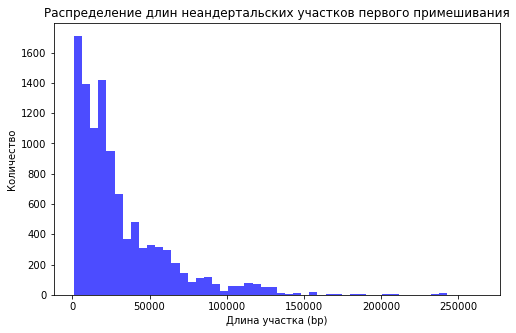

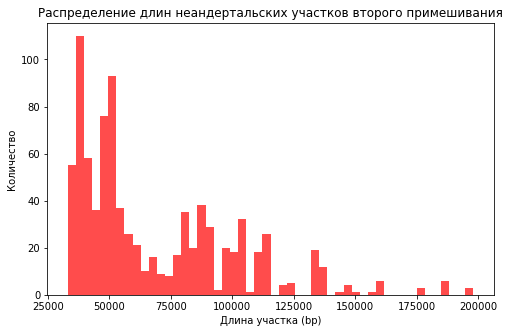

In [10]:
def compute_chunk_lengths(intervals):
    if not isinstance(intervals, list):
        return []
    lengths = []
    for element in intervals:
        if isinstance(element, list) and len(element) == 2 and isinstance(element[0], (int, float)):
            lengths.append(element[1] - element[0])
        elif isinstance(element, list):
            lengths.extend(compute_chunk_lengths(element))
    return lengths

chunk_lengths1 = compute_chunk_lengths(HMM_ND1)
chunk_lengths2 = compute_chunk_lengths(HMM_ND2)

plt.figure(figsize=(8, 5))
plt.hist(chunk_lengths1, bins=50, alpha=0.7, color='blue')
plt.xlabel("Длина участка (bp)")
plt.ylabel("Количество")
plt.title("Распределение длин неандертальских участков первого примешивания")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(chunk_lengths2, bins=50, alpha=0.7, color='red')
plt.xlabel("Длина участка (bp)")
plt.ylabel("Количество")
plt.title("Распределение длин неандертальских участков второго примешивания")
plt.show()

In [11]:
def merge(intervals):
    new_intervals = []
    
    for element in intervals:
        if isinstance(element, list) and len(element) == 2 and isinstance(element[0], (int, float)):
            new_intervals.append(element)
        elif isinstance(element, list):
            new_intervals.extend(merge(element))
    new_intervals.sort()
    merged = []
    for start, end in new_intervals:
        if not merged or merged[-1][1] < start:  
            merged.append([start, end])
        else:
            merged[-1][1] = max(merged[-1][1], end)

    return merged

def inter_len(intervals):
    return sum(end - start for start, end in intervals)

def inter_diff(a, b):
    return subtract(union(a, b), intersect(a, b))

def intersect(a, b):
    i, j = 0, 0
    res = []
    while i < len(a) and j < len(b):
        startA, endA = a[i]
        startB, endB = b[j]
        if endA < startB:
            i += 1
        elif endB < startA:
            j += 1
        else:
            left = max(startA, startB)
            right = min(endA, endB)
            if left < right:
                res.append([left, right])
            if endA < endB:
                i += 1
            else:
                j += 1
    return res

def union(a, b):
    combined = merge(a + b)
    return combined

def subtract(a, b):
    res = []
    i, j = 0, 0
    while i < len(a):
        startA, endA = a[i]
        if j >= len(b):
            res.append([startA, endA])
            i += 1
            continue

        startB, endB = b[j]
        if endA < startB:
            res.append([startA, endA])
            i += 1
        elif endB < startA:
            j += 1
        else:
            if startA < startB:
                res.append([startA, startB])
            if endA <= endB:
                i += 1
            else:
                a[i] = [endB, endA]
                j += 1
    return res

true_intervals = ND_true_tracts[0]
pred_intervals = HMM_ND1

def one_dim_intervals(inter):
    result = []
    for x in inter:
        if isinstance(x, list) and len(x) == 2 and isinstance(x[0], (int, float)):
            result.append(x)
        elif isinstance(x, list):
            result.extend(one_dim_intervals(x))
    return result

true_flat = one_dim_intervals(true_intervals)
pred_flat = one_dim_intervals(pred_intervals)
true_merged = merge(true_flat)
pred_merged = merge(pred_flat)

mismatch_intervals = inter_diff(true_merged, pred_merged)
mismatch_length = inter_len(mismatch_intervals)

sum_true = inter_len(true_merged)
if sum_true > 0:
    mismatch_rate = mismatch_length / sum_true
    
print("Число отличий:", mismatch_length)
print("Общая длина:", sum_true)
print("Отличий на единицу длины:", mismatch_rate)


Число отличий: 8617268.0
Общая длина: 7753890.0
Отличий на единицу длины: 1.111347723529738
